# __Carseats DataSet Using RandomForestRegressor__

### __Importing Data & Libraries__

In [297]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pyplot import subplots
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LassoLarsCV, LassoCV, ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, auc
from sklearn.model_selection import train_test_split, KFold  
from sklearn.feature_selection import RFE


In [298]:
df = pd.read_csv("Carseats.csv")

In [299]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


### __Cleaning Data__

In [300]:
df['Urban_Yes'] = pd.Series(np.zeros(df.shape[0]))
df.loc[df['Urban']=='Yes', 'Urban_Yes'] = 1

df['US_Yes'] = pd.Series(np.zeros(df.shape[0]))
df.loc[df['US']=='Yes', 'US_Yes'] = 1

df['ShelveLoc_rank'] = pd.Series(np.zeros(df.shape[0]))
df.loc[df['ShelveLoc']=='Bad', 'ShelveLoc_rank'] = -1
df.loc[df['ShelveLoc']=='Good', 'ShelveLoc_rank'] = 1

In [301]:
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Urban_Yes,US_Yes,ShelveLoc_rank
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0,1.0,-1.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1.0,1.0,1.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1.0,1.0,0.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,1.0,1.0,0.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,1.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes,1.0,1.0,1.0
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes,0.0,1.0,0.0
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes,1.0,1.0,0.0
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes,1.0,1.0,-1.0


In [302]:
del df["ShelveLoc"]
del df["Urban"]
del df["US"]

In [303]:
df.isnull().sum()

Sales             0
CompPrice         0
Income            0
Advertising       0
Population        0
Price             0
Age               0
Education         0
Urban_Yes         0
US_Yes            0
ShelveLoc_rank    0
dtype: int64

In [304]:
df.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban_Yes,US_Yes,ShelveLoc_rank
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000,0.705000,0.645000,-0.027500
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528,0.456614,0.479113,0.672961
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000,0.000000,0.000000,-1.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000,0.000000,0.000000,0.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000,1.000000,1.000000,0.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000,1.000000,1.000000,0.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000,1.000000,1.000000,1.000000


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sales           400 non-null    float64
 1   CompPrice       400 non-null    int64  
 2   Income          400 non-null    int64  
 3   Advertising     400 non-null    int64  
 4   Population      400 non-null    int64  
 5   Price           400 non-null    int64  
 6   Age             400 non-null    int64  
 7   Education       400 non-null    int64  
 8   Urban_Yes       400 non-null    float64
 9   US_Yes          400 non-null    float64
 10  ShelveLoc_rank  400 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 34.5 KB


### __Train/Testing Set Split__

In [306]:
X = df.iloc[:, 1:11]
X['intercept']= np.ones(df.shape[0])
y = df.iloc[:, 0]

In [307]:
X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban_Yes,US_Yes,ShelveLoc_rank,intercept
0,138,73,11,276,120,42,17,1.0,1.0,-1.0,1.0
1,111,48,16,260,83,65,10,1.0,1.0,1.0,1.0
2,113,35,10,269,80,59,12,1.0,1.0,0.0,1.0
3,117,100,4,466,97,55,14,1.0,1.0,0.0,1.0
4,141,64,3,340,128,38,13,1.0,0.0,-1.0,1.0


In [308]:
y.head()

0     9.50
1    11.22
2    10.06
3     7.40
4     4.15
Name: Sales, dtype: float64

In [309]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 21)

### __RandomForestRegressor Integration__

In [310]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state= 21)

In [311]:
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

In [312]:
y_pred = rfr.predict(X_test)

In [313]:
y_pred

array([ 4.0171,  6.6718,  5.9925,  5.5445,  5.9706,  5.0019, 10.391 ,
        6.039 ,  9.8483,  5.6197,  9.7973,  4.9345,  6.1177,  5.8937,
        7.0759,  6.4713,  6.3832,  9.8182, 11.4889,  6.0462,  6.7425,
        9.3316,  6.3451,  4.5415,  7.1058,  7.4658,  8.7793,  6.6685,
        6.4571,  4.016 ,  5.4231,  4.8096,  9.6727,  6.2988,  7.717 ,
        5.0364,  5.6458, 10.6177,  7.5312,  7.7889,  7.0498, 11.9651,
       10.9164,  4.7634,  6.919 ,  6.3247,  9.6112,  6.3772,  6.2635,
        6.8575, 10.4996,  7.1075, 10.4515,  6.5092,  6.2986, 10.1227,
        9.2042,  4.9924,  5.2505,  7.7702,  5.2848, 10.6396,  7.9327,
        5.8169,  5.7017,  5.2424,  4.8875,  7.1854,  7.9074,  7.3752,
        6.9343,  6.9259,  6.8121,  6.6671,  5.3282,  4.4153,  5.022 ,
        7.6934,  8.493 ,  5.3089,  7.7822,  7.3608, 12.5928,  6.4659,
        7.4767,  5.1818,  4.7099,  5.9791,  4.7759,  9.1357,  5.8695,
        8.4597, 11.1238,  8.6125, 12.3536,  5.8366,  5.2616,  8.1419,
        7.5627,  5.4

In [314]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [315]:
mean_absolute_error(y_pred, y_test)

1.2626566666666659

In [316]:
mean_squared_error(y_pred, y_test)

2.564179406333332

In [317]:
r2_score(y_pred, y_test)

0.3343133367975518

In [318]:
param_grid = {
    'n_estimators': [100,200,300], 
    'max_depth': [10,20,30], 
    'min_samples_split': [2,5,10], 
    'min_samples_leaf': [1,2,4]
}

In [319]:
from sklearn.model_selection import GridSearchCV

In [320]:
rfr_cv = GridSearchCV(estimator= rfr, param_grid=param_grid, cv=3, scoring= "neg_mean_squared_error", n_jobs= -1)

In [321]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [322]:
y_pred = rfr_cv.predict(X_test)

In [323]:
mean_absolute_error(y_pred, y_test)

1.2462858333333329

In [324]:
mean_squared_error(y_pred, y_test)

2.516016317490742

In [325]:
r2_score(y_pred, y_test)

0.33941643570933033

In [327]:
e_model = sm.OLS(y_train, X_train)
results = e_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     183.7
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          5.42e-114
Time:                        14:05:43   Log-Likelihood:                -405.12
No. Observations:                 280   AIC:                             832.2
Df Residuals:                     269   BIC:                             872.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CompPrice          0.0927      0.005     18.437      0.000       0.083       0.103
Income             0.0168      0.002      7.354      0.000       0.012       0.021
Advertising        0.1200      0.013      9.099      0.000       0.094       0.146
Population         0.0006      0.000      1.276      0.203      -0.000       0.001
Price             -0.0975      0.003    -28.723      0.000      -0.104      -0.091
Age               -0.0508      0.004    -12.772      0.000      -0.059      -0.043
Education         -0.0211      0.024     -0.879      0.380      -0.068       0.026
Urban_Yes          0.1607      0.139      1.159      0.247      -0.112       0.434
US_Yes            -0.1811      0.185     -0.976      0.330      -0.546       0.184
ShelveLoc_rank     2.4939      0.093     26.932      0.000       2.312       2.676
intercept          8.1695      0.734     11.137      0.000       6.725       9.614
==============================================================================
Omnibus:                        0.438   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.497
Skew:                           0.093   Prob(JB):                        0.780
Kurtosis:                       2.912   Cond. No.                     4.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [326]:
def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

def gains_chart(actuals, predictions, num_buckets=10):
    # Combine actuals and predictions into a single DataFrame
    results = np.asarray([actuals, predictions]).T
    # Sort by predictions descending
    results = results[results[:,1].argsort()[::-1]]

    # Calculate total number of instances and cumulative count
    total_count = len(results)
    cumulative_count = np.arange(1, total_count + 1) / total_count

    # Calculate cumulative actuals
    cumulative_actuals = np.cumsum(results[:,0])

    # Calculate cumulative baseline (if predictions were randomly sorted)
    baseline = np.arange(1, total_count + 1) * np.sum(actuals) / total_count

    # Calculate gains
    gains = cumulative_actuals / np.sum(actuals)

    # Calculate AUC (Area Under the Gains Curve)
    auc_score = auc(cumulative_count, gains)

    # Plotting the gains chart
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_count, gains, marker='o', linestyle='-', color='b', label=f'Gains Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Baseline')
    plt.title('Gains Chart for Regression Model')
    plt.xlabel('Percentage of Population')
    plt.ylabel('Cumulative Gains')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print AUC
    print(f"Area Under the Gains Curve (AUC): {auc_score:.4f}")

def lift_chart_regression(actuals, predictions, num_buckets=10):
    # Create helper function for displaying lift charts
    # Combine actuals and predictions into a single DataFrame
    results = np.asarray([actuals, predictions]).T
    # Sort by predictions descending
    results = results[results[:,1].argsort()[::-1]]

    # Calculate total number of instances and cumulative count
    total_count = len(results)
    cumulative_count = np.arange(1, total_count + 1) / total_count

    # Calculate cumulative actuals
    cumulative_actuals = np.cumsum(results[:,0])

    # Calculate cumulative baseline (if predictions were randomly sorted)
    baseline = np.arange(1, total_count + 1) * np.sum(actuals) / total_count

    # Calculate lift
    lift = cumulative_actuals / baseline

    # Calculate cumulative lift
    cumulative_lift = np.cumsum(lift)

    # Plotting the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_count, cumulative_lift, marker='o', linestyle='-', color='b', label='Lift Curve')
    plt.plot([0, 1], [1, 1], linestyle='--', color='r', label='Baseline')
    plt.title('Lift Chart for Regression Model')
    plt.xlabel('Percentage of Population')
    plt.ylabel('Lift')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [328]:
e_model_test = sm.OLS(y_test, X_test)
results = e_model_test.fit()

In [329]:
results_train = e_model.fit()

predict_train = predict(X_train, results_train)
print('mse train:', mse(y_train, predict_train))

results_test = e_model_test.fit()
predict_test = predict(X_test, results_test)
print('mse test:', mse(y_test, predict_test))

mse train: 1.0574005848100856
mse test: 0.9846784288782763


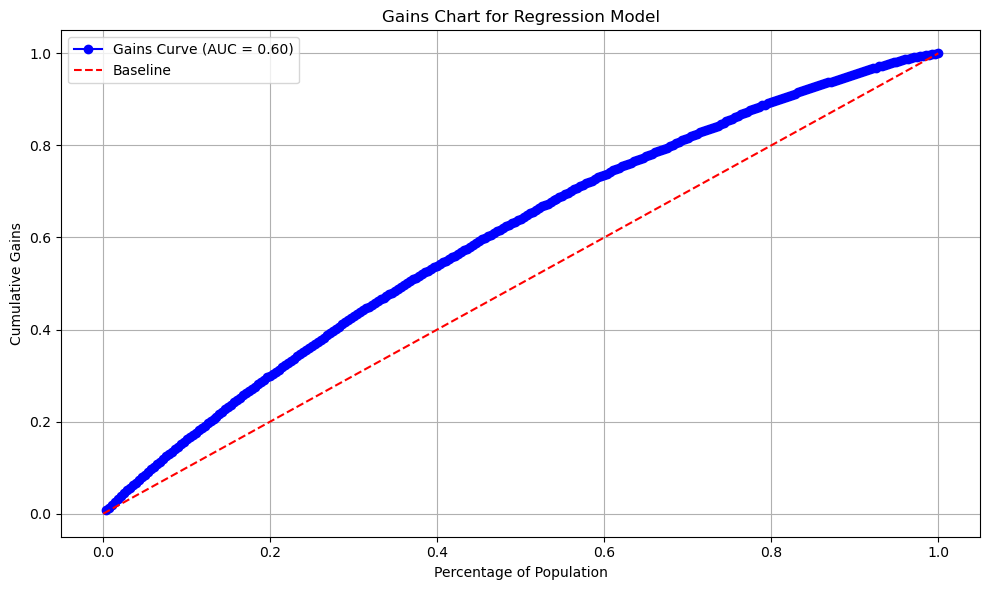

Area Under the Gains Curve (AUC): 0.5985


In [330]:
gains_chart(y_train, predict_train)

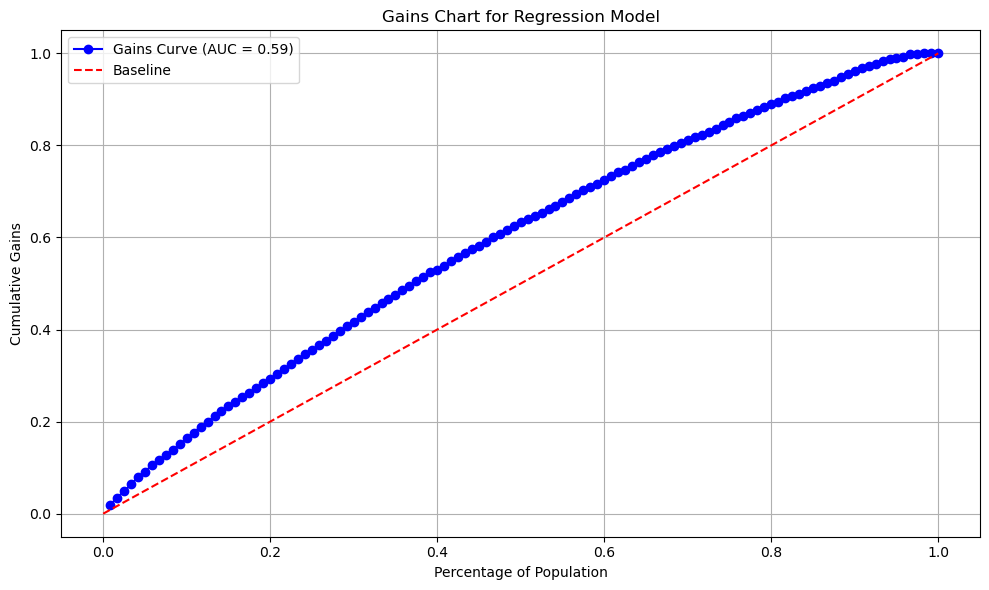

Area Under the Gains Curve (AUC): 0.5944


In [331]:
gains_chart(y_test, predict_test)

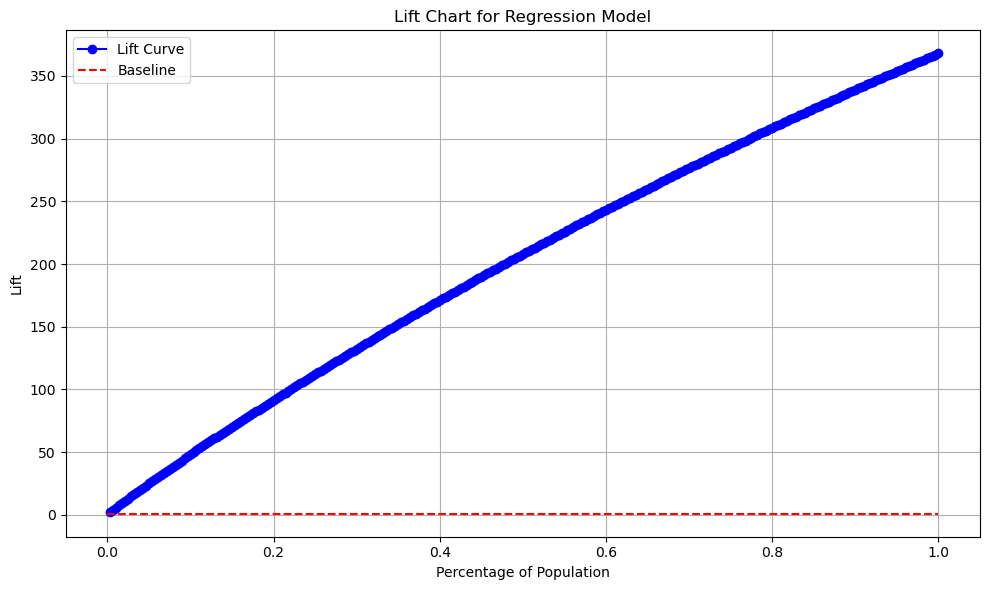

In [332]:
lift_chart_regression(y_train, predict_train)

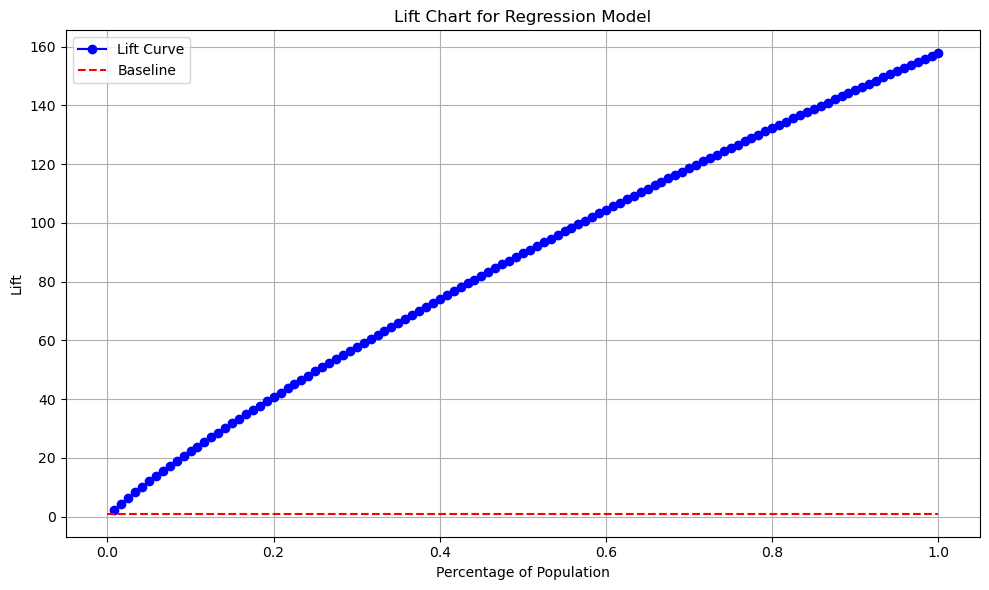

In [333]:
lift_chart_regression(y_test, predict_test)